# Actividad 6
En esta semana entramos al tema de realizar **pronósticos de series de tiempo**, para lo que se requiere contar con un modelo para predecir valores futuros en base a los valores históricos pasados.

Describiremos esquemáticamente que requisitos requiere cumplir una serie de tiempo para crear un modelo de pronóstico.

In [2]:
# Pronóstico de Series de Tiempo
# Feb 15, 2021
# Importamos las bibliotecas a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Bibliotecas para el análisis de Series de Tiempo y Modelos de Pronóstico
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf

import pandas.util.testing as tm

# Suprimir mensajes de alertas de cambios futuros
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Matplotlib mostrará los resultados en la Notebook de Jupyter
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
# En esta celda se hacen todas las operaciones de preparar el DataFrame df_meteo
# 
# En esta nueva Jupyter Notebook, en una celda vamos a concentrar todas las operaciones
# de transformación del dataframe original df_dist

# Analizaremos los datos de Información Estadística Climatológica del Servico Meteorológico Nacional 
# de CONAGUA que podemos descargar del sitio:
# (https://smn.conagua.gob.mx/es/climatologia/informacion-climatologica/informacion-estadistica-climatologica) 

# Tomar la dirección URL del archivo en formato 'raw'
# url = 'https://raw.githubusercontent.com/carloslizarragac/FisicaComputacional1/master/Actividad1/Guaymas26292.txt'
url = 'https://raw.githubusercontent.com/Ferna45/Fisica-Computacional-1/master/Actividad-6/Base_de_Datos.txt'

# Definimos los nombres de las columnas
# El archivo tiene códigos ASCII extendido (Español), encoding='cp1251' Windows (Europa Occidental)
# El separador de datos es de uno o más espacios, sep='\s+'
# Se brincará los primeros 19 renglones y el último, afirmamos que no nay encabezado
# Se procesan los datos utilizando Python, engine='python' 
my_cols = ['Fecha', 'Precip', 'Evap', 'TMax', 'TMin']
df_Datos = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')

# Hacemos una copia de trabajo y preservamos el dataframe original
df_Comondu = df_Datos.copy()

# Reemplazamos los textos 'Nulo' por espacio en blanco ''
str_Nulo = 'Nulo'
df_3068 = df_Comondu.replace(to_replace=str_Nulo, value='', regex=True)

# Deseamos convertir los valores de las variables ambientales a núm. flotantes 
cols_list = ['Precip', 'Evap', 'TMax', 'TMin']
for cols in cols_list:
  df_3068[cols] = pd.to_numeric(df_3068[cols], errors='coerce')

# Volvemos a hacer una pausa y definimos un nuevo dataframe por si hay que regresarse.
df_BCS = df_3068.copy()

# Pandas tiene la función pd.to_datetime que convierte una cadena en tipo datetime64[ns]
# Intentamos a ver si Python reconoce el formato en nuestro caso. 
# Agregamos la opción de que el primer dato es el día (dayfirst=True)
df_BCS['Fecha']=pd.to_datetime(df_BCS['Fecha'], dayfirst=True).copy()

# Buscamos ahora añadir dos columnas adicionales: df['Año'], df['Mes']
# Usaremos la función .dt.year y .dt.strftime(%b) para extraer el Año 
# y Mes (Abreviado) de la Fecha
df_BCS['Año'] = df_BCS['Fecha'].dt.year
df_BCS['Mes'] = df_BCS['Fecha'].dt.strftime('%b')

# Definimos un nuevo DataFrame para el análisis de los datos meteorológicos. 
# Será nuestro nuevo punto de partida.
df_meteo = df_BCS.copy()

# Hacemos una copia del último DataFrame para realizar nuevas operaciones
df_meteo_BCS = df_meteo.copy()
# Redefinimos el índice del DataFrame a que sea la variable 'Fecha'
df_meteo_BCS = df_meteo_BCS.set_index('Fecha')

# Verificamos
df_meteo_BCS.info()
#print(df_meteo_ts.head())
#print(df_meteo_ts.tail())

# Seleccionaremos un conjunto de años de 30 años, creando las colecciones de datos   
df_50 = df_meteo_BCS[(df_meteo_BCS['Año'] >= 1957) & (df_meteo_BCS['Año'] < 1987)]
df_80 = df_meteo_BCS[(df_meteo_BCS['Año'] >= 1987) & (df_meteo_BCS['Año'] < 2018)]

# Estas 2 colecciones serán nuestras Series de Tiempo (DataFrames) para el análisis

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 21633 entries, 1957-03-01 to 2017-12-31
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  21582 non-null  float64
 1   Evap    19448 non-null  float64
 2   TMax    21576 non-null  float64
 3   TMin    21588 non-null  float64
 4   Año     21633 non-null  int64  
 5   Mes     21633 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 1.2+ MB


Definimos una función para probar la Estacionaridad de una Serie de Tiempo usando la **Prueba Aumentada de Dickey-Fuller(ADF)**.

In [4]:
# Función para probar la estacionaridad de una serie de tiempo: 'timeseries'
   
def test_stationarity(df_ts):
    
    #Determinar la Estadística de promedios móviles
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    
    # Define el tamaño de la figura
    plt.rcParams["figure.figsize"] = (12,6)

    #Graficar la Estadística de promedios móviles 
    plt.plot(df_ts, color='darkorange',label='Original')
    plt.plot(rolmean, color='darkgreen', label='Rolling Mean')
    plt.plot(rolstd, color='rebeccapurple', label = 'Rolling Std Deviation')
 
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
 
    #Realiza la Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

# Actividad 1
Tomar una serie de datos en un periodo sin huecos **(Tmax, Tmin)** de la estación que se está analizando, para probar si es una serie de tiempo estacionaria o hacer las transformaciones para convertirla en una. 

Definimos una serie de tiempo a probar...

Temperatura Máxima


In [104]:
#Creamos la primer serie de Tiempo para analizar, haciendo una copia de la epoca de 1980 a 2017
#O el periodo que se desee. Podemos regresar a este punto las veces que sea necesario definir.

#Fechas de inicio y fin, para filtrar la informacion.
start, end = '2010-01','2012-12'

ts_80=df_80.loc[start:end].copy()
ts_80.head()

,Precip,Evap,TMax,TMin,Año,Mes
Fecha,,,,,,
2010-01-01,0.0,3.6,30.0,5.0,2010,Jan
2010-01-02,0.0,3.3,30.5,7.0,2010,Jan
2010-01-03,0.0,3.8,29.5,6.8,2010,Jan
2010-01-04,0.0,4.5,30.5,5.0,2010,Jan
2010-01-05,0.0,3.1,30.7,5.1,2010,Jan


In [105]:
#veamos su encabezado
ts_80['TMax'].head()

Fecha
2010-01-01    30.0
2010-01-02    30.5
2010-01-03    29.5
2010-01-04    30.5
2010-01-05    30.7
Name: TMax, dtype: float64

In [106]:
#Definimos la serie de tiempo con la temperatura máxima que vamos a estudiar
#dándola un nombre cualquiera

ts_Prueba_Max =ts_80['TMax'].copy()

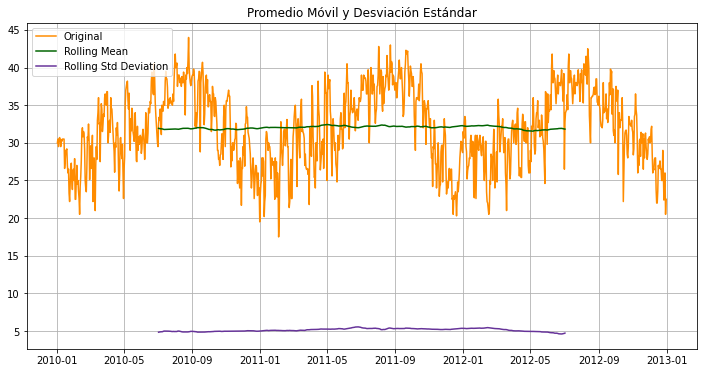

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.474504
p-value                           0.121802
#Lags Used                       22.000000
Number of Observations Used    1073.000000
Critical Value (1%)              -3.436459
Critical Value (5%)              -2.864237
Critical Value (10%)             -2.568206
dtype: float64


In [107]:
#Realizando la prueba de estacionaridad de Temperatura Máxima

test_stationarity(ts_Prueba_Max)

Notamos que el promedio móvil es constante y el valor p de ADF: p > 0.05 (0.058019).
La serie es estacionaria, el promedio móvil y la desviación estandar son constantes.

**Temperatura Mínima**

In [72]:
#Creamos la primer serie de Tiempo para analizar, haciendo una copia de la epoca de 1980 a 2017
#O el periodo que se desee. Podemos regresar a este punto las veces que sea necesario definir.

#Fechas de inicio y fin, para filtrar la informacion.
start, end = '2015-01','2017-12'

ts_80s=df_80.loc[start:end].copy()
ts_80s.head()

,Precip,Evap,TMax,TMin,Año,Mes
Fecha,,,,,,
2015-01-01,0.0,1.0,21.5,12.0,2015,Jan
2015-01-02,0.0,4.9,24.0,8.6,2015,Jan
2015-01-03,0.0,4.1,22.5,4.0,2015,Jan
2015-01-04,0.0,3.3,23.5,3.8,2015,Jan
2015-01-05,0.0,4.0,28.2,3.6,2015,Jan


In [73]:
#veamos su encabezado
ts_80s['TMin'].head()

Fecha
2015-01-01    12.0
2015-01-02     8.6
2015-01-03     4.0
2015-01-04     3.8
2015-01-05     3.6
Name: TMin, dtype: float64

In [74]:
#Definimos la serie de tiempo con la temperatura máxima que vamos a estudiar
#dándola un nombre cualquiera

ts_Prueba_Min =ts_80s['TMin'].copy()

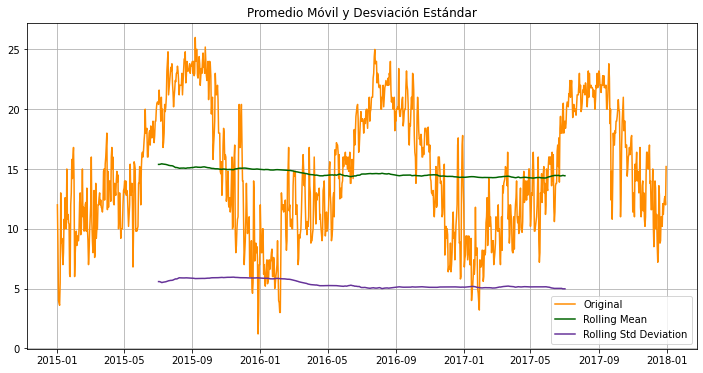

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.463754
p-value                           0.124544
#Lags Used                       10.000000
Number of Observations Used    1085.000000
Critical Value (1%)              -3.436391
Critical Value (5%)              -2.864207
Critical Value (10%)             -2.568190
dtype: float64


In [75]:
#Realizando la prueba de estacionaridad de Temperatura Mínima

test_stationarity(ts_Prueba_Min)

Notamos que el promedio móvil es constante y el valor p de ADF: p > 0.05 (0.1245544). La serie es estacionaria, el promedio móvil y la desviación estandar son constantes.

La **Tendencia** y la **Estacionalidad** hacen que una serie no sea estacionaria.\
Primero trabajaremos para lograr que la **Tendencia sea constante**.\
Hay muchas formas para reducir la tendencia. Es hacer cambio de escalas: log(x), sqrt(x), raiz_cúbica(x),... la idea es disminuir la tendencia para valores grandes de x.

Temperatura Máxima

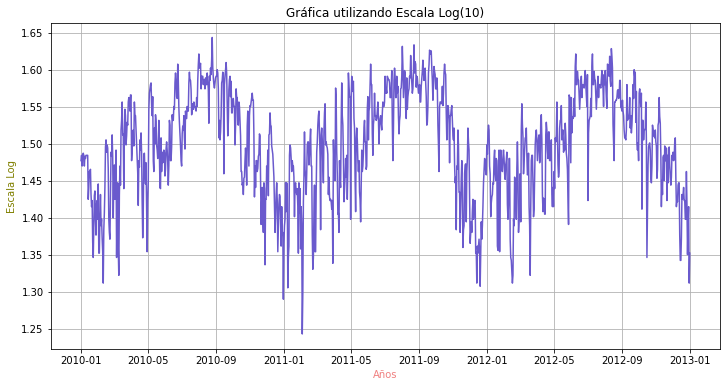

In [108]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_Prueba_log = np.log10(ts_Prueba_Max)
plt.plot(ts_Prueba_log, color='slateblue')
plt.xlabel('Años',color='lightcoral')
plt.ylabel('Escala Log',color='olive')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();


Temperatura Mínima

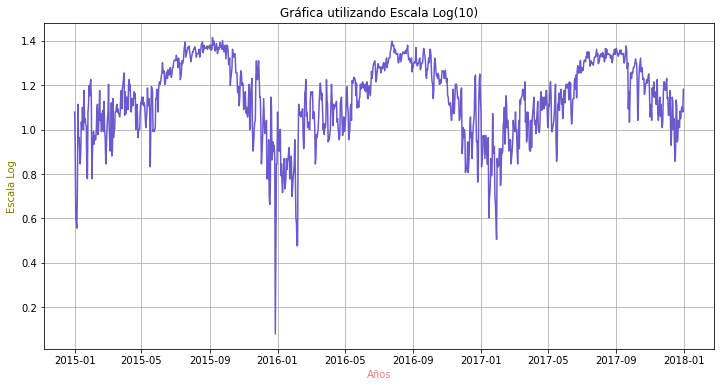

In [76]:
# Seleccionamos la función logaritmo (base 10) y graficamos (La escala en eje-y es Log)
ts_PruebaMin_log = np.log10(ts_Prueba_Min)
plt.plot(ts_PruebaMin_log, color='slateblue')
plt.xlabel('Años',color='lightcoral')
plt.ylabel('Escala Log',color='olive')
plt.title('Gráfica utilizando Escala Log(10)')
plt.grid()
plt.show();


Temperatura Máxima

Vamos a calcular el **Promedio móvil** de ts_Prueba_log con ventana de 365 y graficar para ver el contraste con la de arriba.

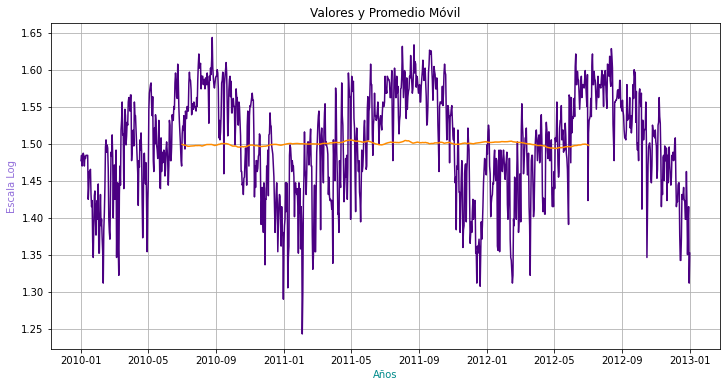

In [109]:
moving_avg = ts_Prueba_log.rolling(365, center=True).mean()
plt.plot(ts_Prueba_log, color='indigo')
plt.plot(moving_avg, color = 'darkorange')
plt.xlabel('Años',color='darkcyan')
plt.ylabel('Escala Log',color='mediumpurple')
plt.title('Valores y Promedio Móvil')
plt.grid()
plt.show();

In [110]:
ts_Prueba_log_moving_ave_diff = ts_Prueba_log - moving_avg 
ts_Prueba_log_moving_ave_diff.head()

Fecha
2010-01-01   NaN
2010-01-02   NaN
2010-01-03   NaN
2010-01-04   NaN
2010-01-05   NaN
Name: TMax, dtype: float64

In [111]:
ts_Prueba_log_moving_ave_diff.dropna(inplace=True)
ts_Prueba_log_moving_ave_diff.head()

Fecha
2010-07-02    0.014257
2010-07-03    0.025091
2010-07-04    0.020119
2010-07-05    0.039622
2010-07-06    0.009760
Name: TMax, dtype: float64

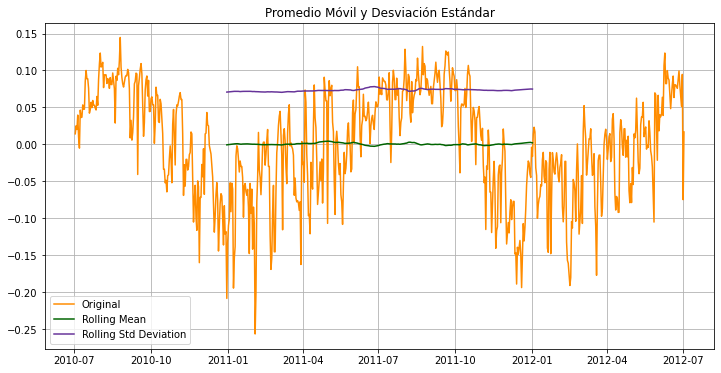

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -3.903041
p-value                          0.002013
#Lags Used                       6.000000
Number of Observations Used    725.000000
Critical Value (1%)             -3.439402
Critical Value (5%)             -2.865535
Critical Value (10%)            -2.568897
dtype: float64


In [112]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_Prueba_log_moving_ave_diff)


Ahora el valor p < 0.05 con (0.002013), es decir que podemos rechazar la hipótesis nula de que la serie de tiempo no es estacionaria y **afirmar que la serie de tiempo es estacionaria con 99% de confianza**. (Hay que jugar con el parámetro 'halflife', en este caso se usaron 30 días).\
Podemos decir que que la serie es estacionaria, pues tanto el promedio móvil y la desviación estándar son constantes.\
Vamos a trabajar con la **estacionalidad** para las variaciones de las estaciones del año.


Temperatura Mínima

Vamos a calcular el Promedio móvil de ts_test_log con ventana de 365 y graficar para ver el contraste con la de arriba.

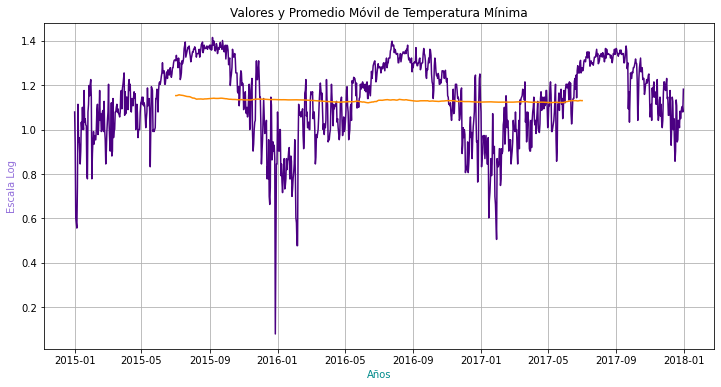

In [77]:
moving_avg = ts_PruebaMin_log.rolling(365, center=True).mean()
plt.plot(ts_PruebaMin_log, color='indigo')
plt.plot(moving_avg, color = 'darkorange')
plt.xlabel('Años',color='darkcyan')
plt.ylabel('Escala Log',color='mediumpurple')
plt.title('Valores y Promedio Móvil de Temperatura Mínima')
plt.grid()
plt.show();

In [78]:
ts_PruebaMin_log_moving_ave_diff = ts_PruebaMin_log - moving_avg 
ts_PruebaMin_log_moving_ave_diff.head()

Fecha
2015-01-01   NaN
2015-01-02   NaN
2015-01-03   NaN
2015-01-04   NaN
2015-01-05   NaN
Name: TMin, dtype: float64

In [79]:
ts_PruebaMin_log_moving_ave_diff.dropna(inplace=True)
ts_PruebaMin_log_moving_ave_diff.head()

Fecha
2015-07-02    0.156565
2015-07-03    0.181389
2015-07-04    0.160684
2015-07-05    0.164055
2015-07-06    0.123860
Name: TMin, dtype: float64

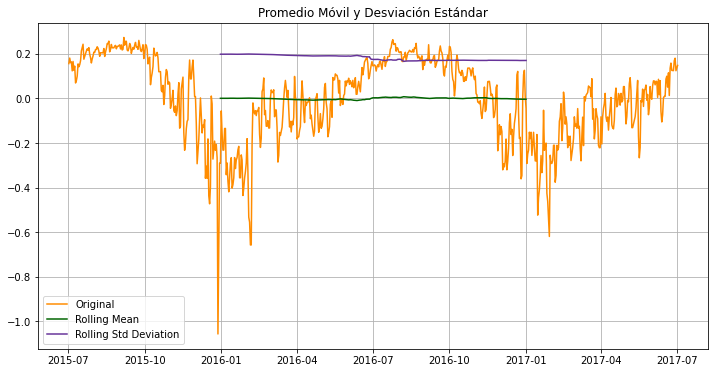

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                  -2.155770
p-value                          0.222688
#Lags Used                       9.000000
Number of Observations Used    722.000000
Critical Value (1%)             -3.439440
Critical Value (5%)             -2.865551
Critical Value (10%)            -2.568906
dtype: float64


In [80]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log
test_stationarity(ts_PruebaMin_log_moving_ave_diff)

Ahora el valor p > 0.05 con (0.222688),Aún la serie de tiempo no es estacionaria. Cambiaremos el tipo de promedio móvil a Exponencial (Exponential Weighted Moving), función de pandas pd.ewm()







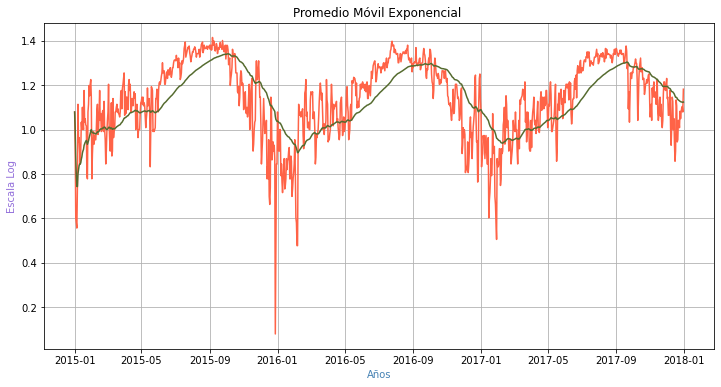

In [81]:
# Repetimos el cálculo usando promedios móviles exponenciales, 
# el parámetro 'halflife' representa el número de días que tienen cierta influencia
# en el promedio, pero su influencia decae exponencialmente.  

EWM_avg = ts_PruebaMin_log.ewm(halflife=30).mean()
plt.plot(ts_PruebaMin_log, color='tomato')
plt.plot(EWM_avg, color = 'darkolivegreen')
plt.xlabel('Años',color='steelblue')
plt.ylabel('Escala Log',color='mediumpurple')
plt.title('Promedio Móvil Exponencial ')
plt.grid()
plt.show();

In [82]:
EWM_avg.head()

Fecha
2015-01-01    1.079181
2015-01-02    1.006004
2015-01-03    0.868233
2015-01-04    0.793603
2015-01-05    0.743925
Name: TMin, dtype: float64

In [83]:
# Probamos la estacionarida de la diferencia 
ts_PruebaMin_log_EWM_avg_diff = ts_PruebaMin_log - EWM_avg

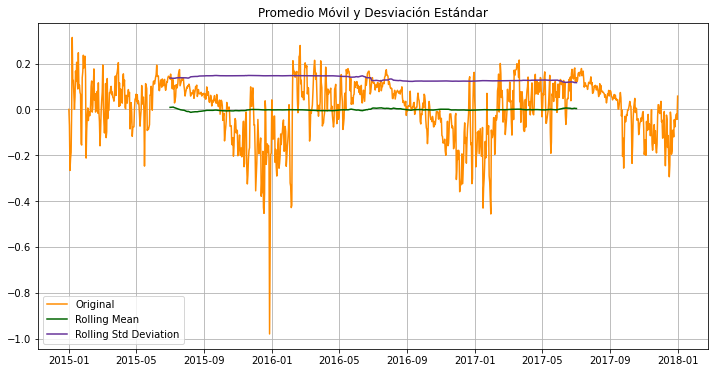

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -3.688873
p-value                           0.004272
#Lags Used                       10.000000
Number of Observations Used    1085.000000
Critical Value (1%)              -3.436391
Critical Value (5%)              -2.864207
Critical Value (10%)             -2.568190
dtype: float64


In [84]:
# Probamos ahora la estacionaridad de la nueva serie de tiempo escalada en Log y usando EWM
test_stationarity(ts_PruebaMin_log_EWM_avg_diff)

Ahora el valor p < 0.05 (0.004272), es decir que podemos **rechazar la hipótesis nula** de que la serie de tiempo **no es estacionaria** y afirmar que la serie de tiempo es **estacionaria con 99% de confianza**. (Hay que jugar con el parámetro 'halflife', en este caso se usaron 30 días).

Podemos decir que la serie **es estacionaria**, pues tanto el promedio móvil exponencial y la desviación estandar son constantes.

Ahora vamos a trabajar con **la estacionalidad** (variaciones debido a las estaciones del año)

Existen dos métodos para eliminar la Estancionalidad:
- Diferenciación discreta (calcular diferencias involucrando un corrimiento 'shift()')\
- Descomposición (Tendencia + Estacionalidad + Residuo) - lo que vimos en la actividad pasada.

Temperatura Máxima

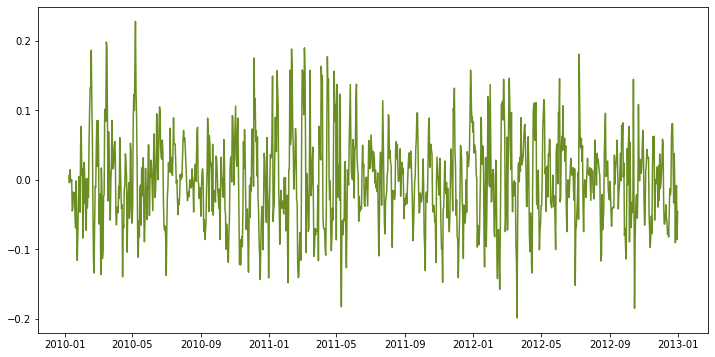

In [113]:
# Diferenciamos usando la función df.shift()
ts_Prueba_log_diff = ts_Prueba_log - ts_Prueba_log.shift(periods=7)
plt.plot(ts_Prueba_log_diff, color='olivedrab');

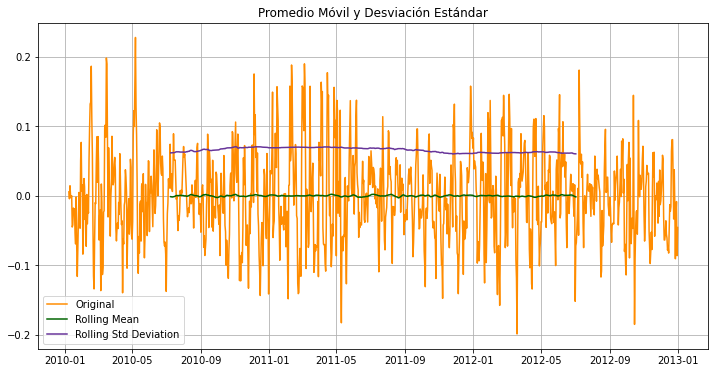

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.604893e+00
p-value                        1.877627e-16
#Lags Used                     2.100000e+01
Number of Observations Used    1.067000e+03
Critical Value (1%)           -3.436493e+00
Critical Value (5%)           -2.864253e+00
Critical Value (10%)          -2.568214e+00
dtype: float64


In [114]:
# Probamos la estacionaridad
ts_Prueba_log_diff.dropna(inplace=True)
test_stationarity(ts_Prueba_log_diff)

In [115]:
# Número de datos utilizados
len(ts_Prueba_log_diff)

1089

Podemos decir que es **estacionaria**, el valor p < 0.05 y la **desviación estándar** no varía mucho.\
La estacionalidad domina.

Temperatura Mínima

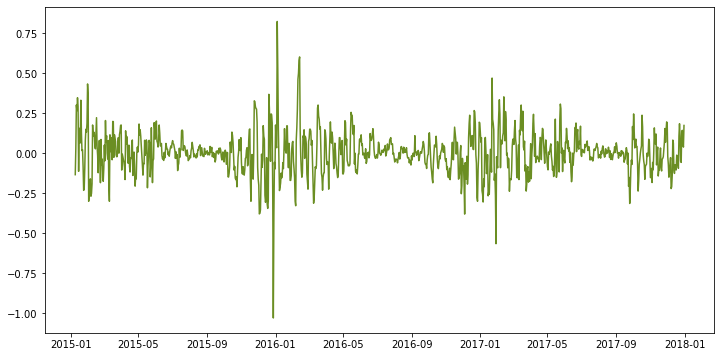

In [85]:
# Diferenciamos usando la función df.shift()
ts_PruebaMin_log_diff = ts_PruebaMin_log - ts_PruebaMin_log.shift(periods=7)
plt.plot(ts_PruebaMin_log_diff, color='olivedrab');

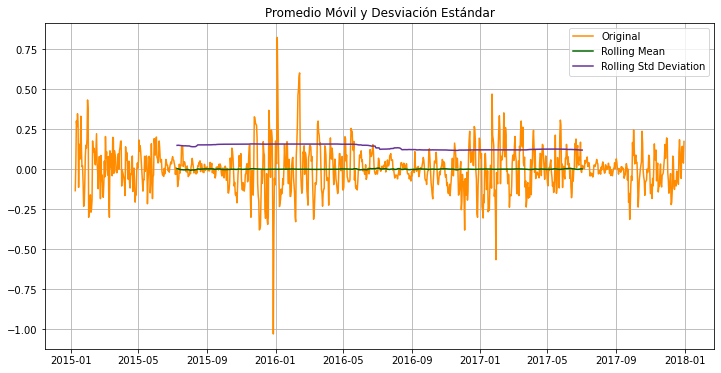

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -7.201989e+00
p-value                        2.352426e-10
#Lags Used                     2.100000e+01
Number of Observations Used    1.067000e+03
Critical Value (1%)           -3.436493e+00
Critical Value (5%)           -2.864253e+00
Critical Value (10%)          -2.568214e+00
dtype: float64


In [86]:
# Probamos la estacionaridad
ts_PruebaMin_log_diff.dropna(inplace=True)
test_stationarity(ts_PruebaMin_log_diff)

In [87]:
# Número de datos utilizados
len(ts_PruebaMin_log_diff)

1089

Veamos el siguientes **método de descomposición** que se usó en la actividad anterior.

Temperatura Máxima

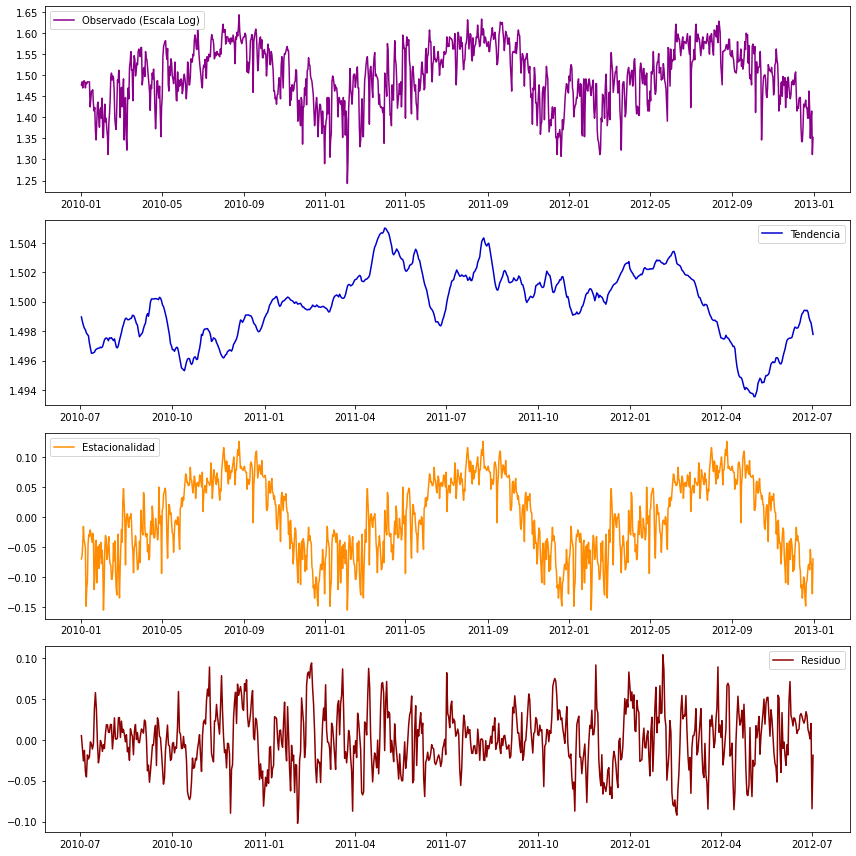

In [ ]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_Prueba_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_Prueba_log, label='Observado (Escala Log)', color='darkmagenta')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='mediumblue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='darkorange')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo', color='darkred')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

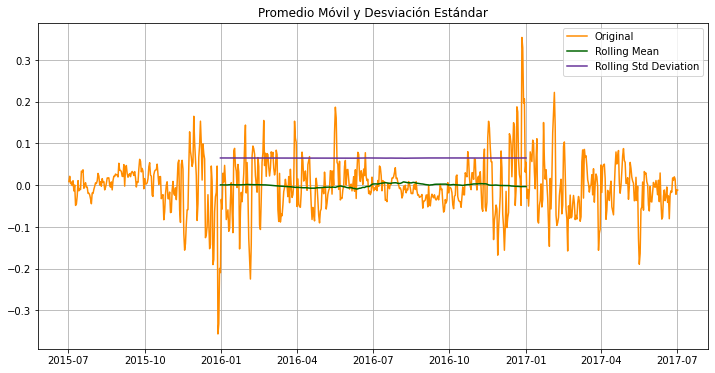

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.510362e+00
p-value                        1.104325e-08
#Lags Used                     1.800000e+01
Number of Observations Used    7.130000e+02
Critical Value (1%)           -3.439555e+00
Critical Value (5%)           -2.865602e+00
Critical Value (10%)          -2.568933e+00
dtype: float64


In [116]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_Prueba_log_decompose = residue 
ts_Prueba_log_decompose.dropna(inplace=True)
test_stationarity(ts_Prueba_log_decompose)

Es estacionaria esta serie ya que la prueba da un valor p < 0.05, me da $2.715*10^{-11}$. Se puede afirmar que es una serie de tiempo estacionaria con más de **99% de confianza**.

Temperatura Mínima

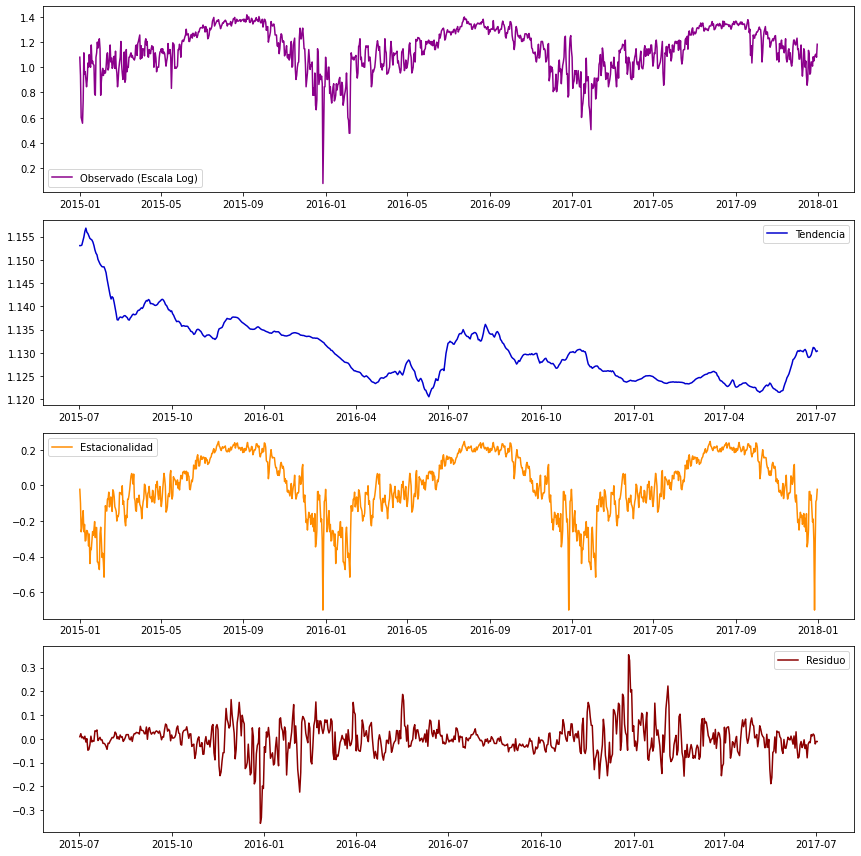

In [88]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decompositionMin = sm.tsa.seasonal_decompose(ts_PruebaMin_log.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decompositionMin.trend
seasonal = decompositionMin.seasonal
residue = decompositionMin.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_PruebaMin_log, label='Observado (Escala Log)', color='darkmagenta')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia', color='mediumblue')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad', color='darkorange')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo', color='darkred')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

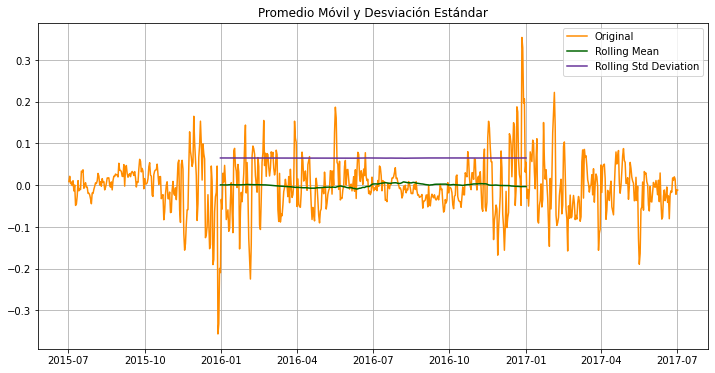

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.510362e+00
p-value                        1.104325e-08
#Lags Used                     1.800000e+01
Number of Observations Used    7.130000e+02
Critical Value (1%)           -3.439555e+00
Critical Value (5%)           -2.865602e+00
Critical Value (10%)          -2.568933e+00
dtype: float64


In [89]:
# Eliminando la Tendencia y Estacionalidad, probamos si la serie Residuo es estacionaria o no...

ts_PruebaMin_log_decompose = residue 
ts_PruebaMin_log_decompose.dropna(inplace=True)
test_stationarity(ts_PruebaMin_log_decompose)

Es estacionaria esta serie ya que la prueba da un valor p < 0.05, me da $1.104325*10^{-08}$ . Se puede afirmar que es una serie de tiempo estacionaria con más de 99% de confianza.

# Actividad 2
Construye los modelos ARIMA para cada Temperatura **Máxima y Mínima**, y contrasta la bondad del ajuste en cada caso, calculando el error de la raíz cuadrada promedio RMSE y sobreponiendo gráficamente ambas series, la observada y la construida con el método ARIMA.

Ya que hemos obtenido una serie de tiempo estacionaria, construiremos un modelo utilizando diferenciación, porque es fácil añadir el error, la tendencia y la estacionalidad a las predicciones.\
Utilizaremos el método **ARIMA**.\
Necesitamos agregar las siguientes 2 líneas en la celda 1, donde cargamos las bibliotecas a la memoria de trabajo.\
from statsmodels.tsa.arima_model import ARIMA.\
from statsmodels.tsa.stattools import acf, pacf.\
Usaremos propiedades de la **Distribución Normal centrada en el promedio y std dev=1**, donde el **95% de los datos caen entre -1.96 y 1.96.**

Temperatura Máxima

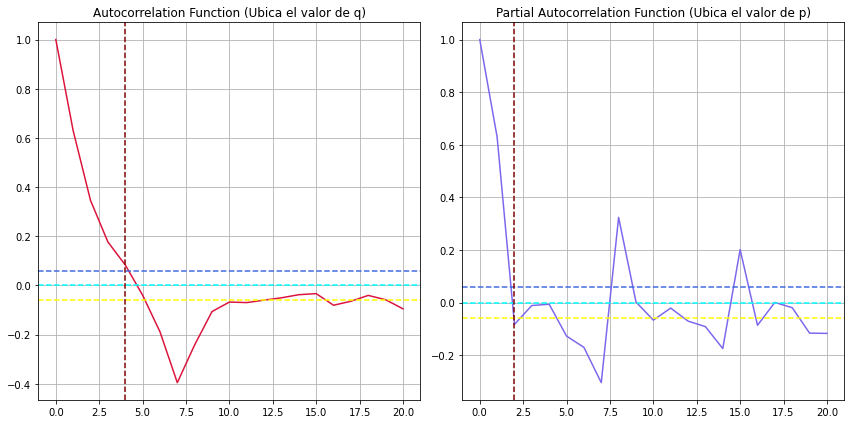

In [ ]:
# Aplicamos ARIMA

lag_acf = acf(ts_Prueba_log_diff, nlags=20)
lag_pacf = pacf(ts_Prueba_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf, color='crimson')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(ts_Prueba_log_diff)), linestyle='--', color='yellow')
plt.axhline(y=1.96/np.sqrt(len(ts_Prueba_log_diff)), linestyle='--', color='royalblue')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='maroon')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf, color='mediumslateblue')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(ts_Prueba_log_diff)), linestyle='--', color='yellow')
plt.axhline(y=1.96/np.sqrt(len(ts_Prueba_log_diff)), linestyle='--', color='royalblue')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='maroon')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

Las líneas punteadas alrededor del cero representan los intervalos de confianza y nos servirán para determinar los valores de **p** y **q** del modelo **ARIMA**.

**P** es donde cruza el PACF el primer nível de confianza superior, que en la gráfica derecha es cercana 2, por lo que p=2.\
**Q** es donde cruzala ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos q=4.\
Con estos valores contruiremos los modelos de **ARIMA**.

Temperatura Mínima

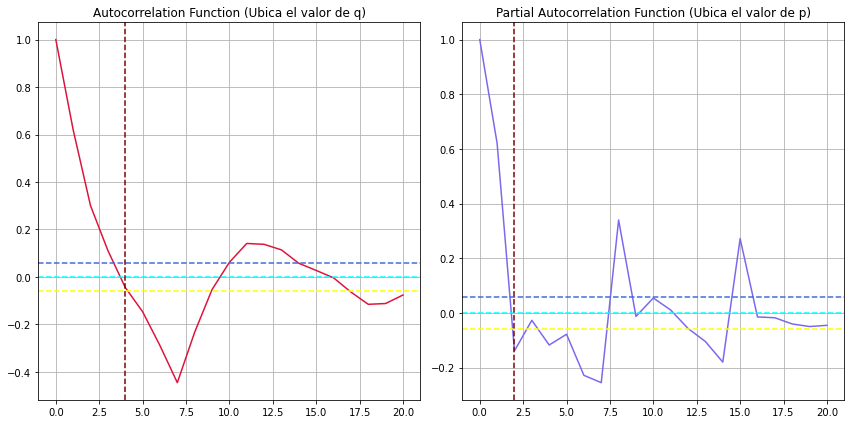

In [90]:
# Aplicamos ARIMA

lag_acf = acf(ts_PruebaMin_log_diff, nlags=20)
lag_pacf = pacf(ts_PruebaMin_log_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf, color='crimson')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(ts_PruebaMin_log_diff)), linestyle='--', color='yellow')
plt.axhline(y=1.96/np.sqrt(len(ts_PruebaMin_log_diff)), linestyle='--', color='royalblue')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=3, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='maroon')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf, color='mediumslateblue')
plt.axhline(y=0, linestyle='--', color='cyan')
plt.axhline(y=-1.96/np.sqrt(len(ts_PruebaMin_log_diff)), linestyle='--', color='yellow')
plt.axhline(y=1.96/np.sqrt(len(ts_PruebaMin_log_diff)), linestyle='--', color='royalblue')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='maroon')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

**P** es donde cruza el PACF el primer nível de confianza superior, que en la gráfica derecha es cercana 2, por lo que **p=2**.\
**Q** es donde cruzala ACF el primer nivel de confianza superior, cercano a 4, por lo que haremos **q=4**.\
Con estos valores contruiremos los modelos de ARIMA.

# Modelo AR 
(Auto Regresión)

Temperatura Máxima

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.TMax   No. Observations:                 1095
Model:                 ARIMA(2, 1, 0)   Log Likelihood                2033.801
Method:                       css-mle   S.D. of innovations              0.038
Date:                Sun, 21 Feb 2021   AIC                          -4059.602
Time:                        21:35:16   BIC                          -4039.608
Sample:                    01-02-2010   HQIC                         -4052.036
                         - 12-31-2012                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0001      0.001     -0.130      0.897      -0.002       0.002
ar.L1.D.TMax    -0.1584      0.030     -5.334      0.000      -0.217      -0.100
ar.L2.D.TMax    -0.1854      0.030     -6.22

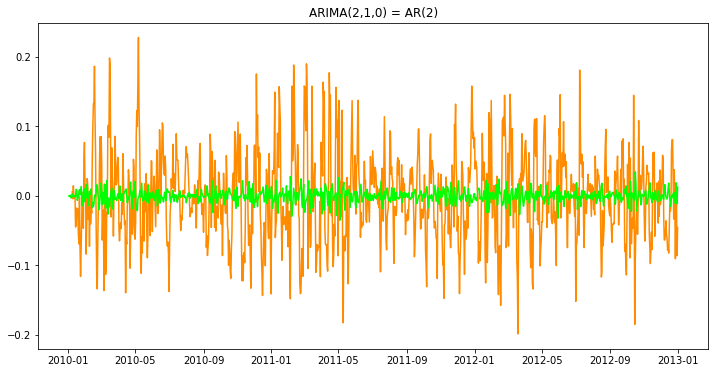

In [117]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_Prueba_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_Prueba_log_diff, color='darkorange')
plt.plot(results_AR.fittedvalues, color='lime')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

Temperatura Mínima

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.TMin   No. Observations:                 1095
Model:                 ARIMA(2, 1, 0)   Log Likelihood                1234.272
Method:                       css-mle   S.D. of innovations              0.078
Date:                Sun, 21 Feb 2021   AIC                          -2460.543
Time:                        21:20:56   BIC                          -2440.549
Sample:                    01-02-2015   HQIC                         -2452.978
                         - 12-31-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.002      0.083      0.934      -0.003       0.004
ar.L1.D.TMin    -0.0939      0.030     -3.160      0.002      -0.152      -0.036
ar.L2.D.TMin    -0.1980      0.030     -6.61

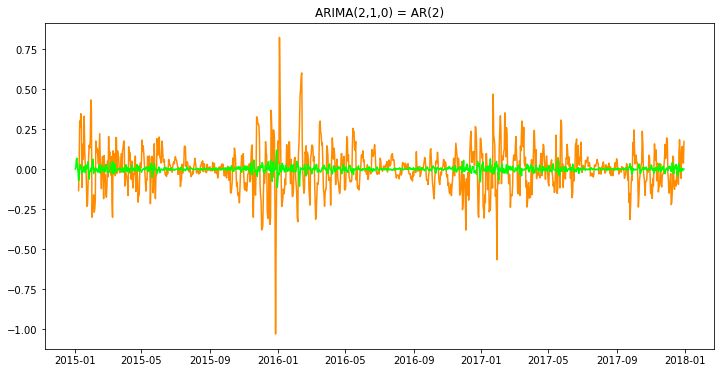

In [91]:
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_PruebaMin_log, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_PruebaMin_log_diff, color='darkorange')
plt.plot(results_AR.fittedvalues, color='lime')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

# Modelo MA
Promedio Móvil

Temperatura Máxima

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.TMax   No. Observations:                 1095
Model:                 ARIMA(0, 1, 4)   Log Likelihood                2077.320
Method:                       css-mle   S.D. of innovations              0.036
Date:                Sun, 21 Feb 2021   AIC                          -4142.640
Time:                        21:35:25   BIC                          -4112.649
Sample:                    01-02-2010   HQIC                         -4131.292
                         - 12-31-2012                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -7.689e-05      0.000     -0.272      0.786      -0.001       0.000
ma.L1.D.TMax    -0.2590      0.030     -8.601      0.000      -0.318      -0.200
ma.L2.D.TMax    -0.2521      0.031     -8.21

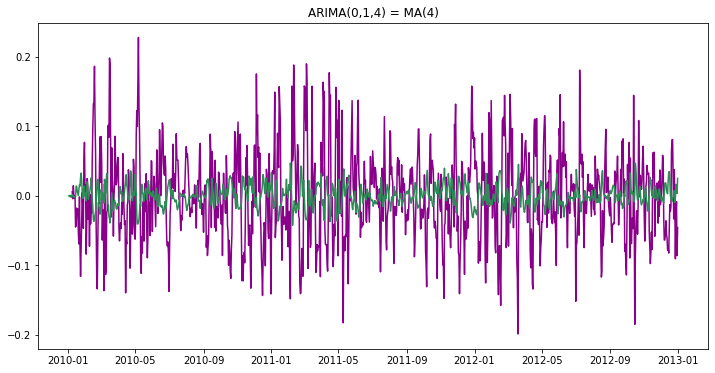

In [118]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_Prueba_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_Prueba_log_diff,color='darkmagenta' )
plt.plot(results_MA.fittedvalues, color='seagreen')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

Temperatura Mínima

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.TMin   No. Observations:                 1095
Model:                 ARIMA(0, 1, 4)   Log Likelihood                1290.941
Method:                       css-mle   S.D. of innovations              0.074
Date:                Sun, 21 Feb 2021   AIC                          -2569.882
Time:                        21:21:55   BIC                          -2539.891
Sample:                    01-02-2015   HQIC                         -2558.533
                         - 12-31-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.001      0.294      0.769      -0.001       0.001
ma.L1.D.TMin    -0.2159      0.030     -7.207      0.000      -0.275      -0.157
ma.L2.D.TMin    -0.2880      0.031     -9.34

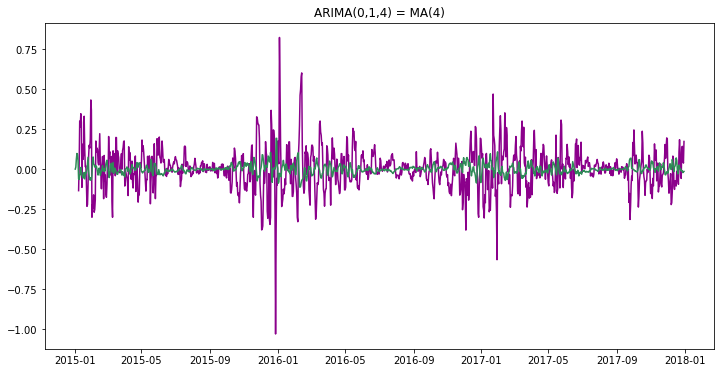

In [92]:
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_PruebaMin_log, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_PruebaMin_log_diff,color='darkmagenta' )
plt.plot(results_MA.fittedvalues, color='seagreen')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

# Modelo ARIMA
Auto-Regresión + Promedio Móvil

Temepratura Máxima

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.TMax   No. Observations:                 1095
Model:                 ARIMA(2, 1, 4)   Log Likelihood                2081.007
Method:                       css-mle   S.D. of innovations              0.036
Date:                Sun, 21 Feb 2021   AIC                          -4146.014
Time:                        21:35:42   BIC                          -4106.026
Sample:                    01-02-2010   HQIC                         -4130.883
                         - 12-31-2012                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -5.895e-05      0.000     -0.254      0.800      -0.001       0.000
ar.L1.D.TMax     0.3466      0.639      0.542      0.588      -0.907       1.600
ar.L2.D.TMax     0.2272      0.352      0.64

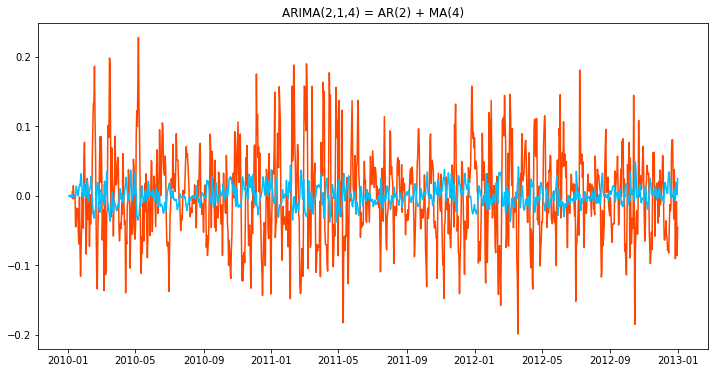

In [119]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_Prueba_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_Prueba_log_diff, color='orangered')
plt.plot(results_ARIMA.fittedvalues, color='deepskyblue')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

Por el criterio AIC tiene dos principios:
- Bonda de Ajuste
-Simplicidad del modelo o principio de parsimonia.\
El criterio AIC nos da: 
- ARIMA (2,1,0): AIC= -4059.602
- ARIMA(0,1,4): AIC= -4142.640
- ARIMA(2,1,4): AIC= -4146.014
El modelo de **ARIMA(2,1,4): AIC=-4146.014** es el mejor **modelo** de las gráfica obtenidas. 


Temperatura Mínima

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.TMin   No. Observations:                 1095
Model:                 ARIMA(2, 1, 4)   Log Likelihood                1294.244
Method:                       css-mle   S.D. of innovations              0.074
Date:                Sun, 21 Feb 2021   AIC                          -2572.489
Time:                        21:22:56   BIC                          -2532.500
Sample:                    01-02-2015   HQIC                         -2557.357
                         - 12-31-2017                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.001      0.300      0.764      -0.001       0.001
ar.L1.D.TMin     1.4039      0.128     10.931      0.000       1.152       1.656
ar.L2.D.TMin    -0.6359      0.114     -5.57

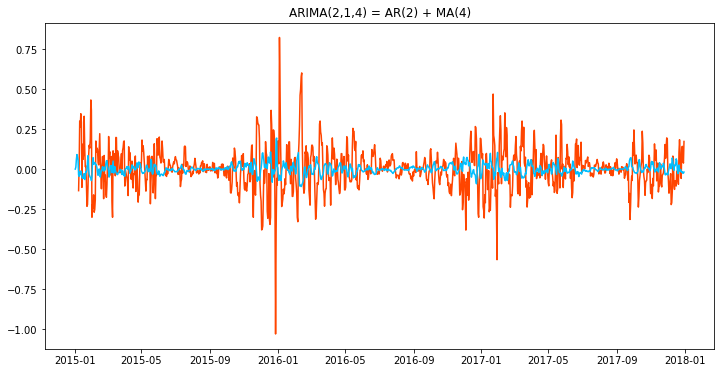

In [93]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_PruebaMin_log, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_PruebaMin_log_diff, color='orangered')
plt.plot(results_ARIMA.fittedvalues, color='deepskyblue')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

Por el criterio AIC tiene dos principios:
- Bonda de Ajuste
- Simplicidad del modelo o principio de parsimonia.\
El criterio AIC nos da:
- ARIMA (2,1,0): AIC= -2460.543
- ARIMA(0,1,4): AIC= -2569.882
- ARIMA(2,1,4): AIC= -2572.489\
El modelo de **ARIMA(2,1,4): AIC=-2572.489** es el **mejor** modelo de las gráfica obtenidas.

# Predicción
Pasos a seguir:
- Obtener los valores de la prediccion y convertirlos en serie. Observaremos que falta un valor en el inicio.
- Luego convertir la deferenciación a escala logaritmica

Temperatura Máxima

In [120]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)


Fecha
2010-01-02   -0.000059
2010-01-03   -0.001026
2010-01-04    0.000873
2010-01-05   -0.000936
2010-01-06   -0.002078
                ...   
2012-12-27   -0.001580
2012-12-28    0.019805
2012-12-29    0.014608
2012-12-30    0.001508
2012-12-31    0.024899
Length: 1095, dtype: float64


In [121]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_Prueba_log, index = ts_Prueba_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
2010-01-01         NaN
2010-01-02    1.484241
2010-01-03    1.468796
2010-01-04    1.485172
2010-01-05    1.486203
dtype: float64
Fecha
2012-12-27    1.348668
2012-12-28    1.414256
2012-12-29    1.429581
2012-12-30    1.313262
2012-12-31    1.377081
dtype: float64


Tomamos el antilogaritmo 

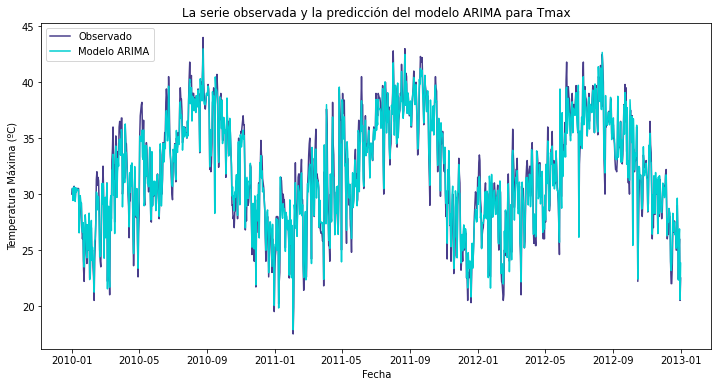

In [123]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_Prueba_Max, label='Observado', color='darkslateblue');
plt.plot(predictions_ARIMA, label='Modelo ARIMA', color='darkturquoise');
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

In [124]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_Prueba_Max)**2))
print('RMSE:', RMSE)

RMSE: 0.9950588599494468


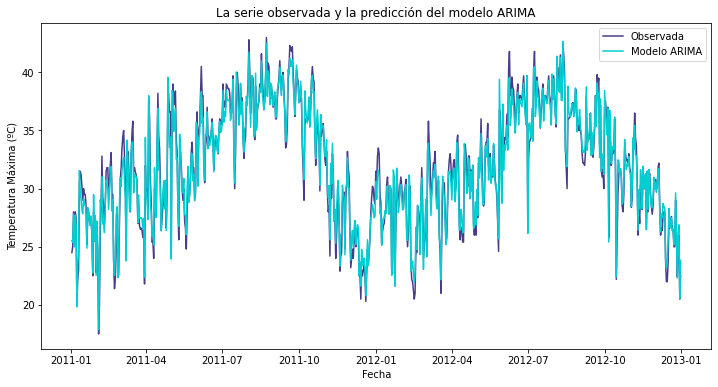

In [125]:
# Graficamos sólo los útimos datos de las series 
ts_Prueba_last = ts_Prueba_Max.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_Prueba_last, label='Observada', color='darkslateblue');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA', color='darkturquoise');
plt.xlabel('Fecha')
plt.ylabel('Temperatura Máxima (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');

Temperatura Mínima

In [94]:
# Definimos una serie de tiempo con las predicciones obtenidas por el método ARIMA
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)

Fecha
2015-01-02    0.000197
2015-01-03    0.011567
2015-01-04    0.060432
2015-01-05    0.091285
2015-01-06    0.077960
                ...   
2017-12-27   -0.019319
2017-12-28   -0.015786
2017-12-29   -0.026162
2017-12-30   -0.025025
2017-12-31   -0.018199
Length: 1095, dtype: float64


In [95]:
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test_log)
predictions_ARIMA_log = pd.Series(ts_PruebaMin_log, index = ts_PruebaMin_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff)
print(predictions_ARIMA_log.head())
print(predictions_ARIMA_log.tail())

Fecha
2015-01-01         NaN
2015-01-02    0.934695
2015-01-03    0.613627
2015-01-04    0.640215
2015-01-05    0.647587
dtype: float64
Fecha
2017-12-27    1.059862
2017-12-28    1.081124
2017-12-29    1.077642
2017-12-30    1.054157
2017-12-31    1.163644
dtype: float64


Tomamos el antilogaritmo

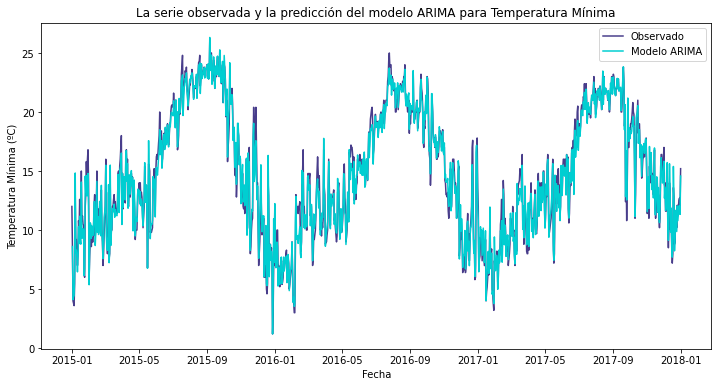

In [101]:
# Regresamos a la escala de Temperatura original 
predictions_ARIMA = 10**(predictions_ARIMA_log)
# Graficamos la serie original y las predicciones con ARIMA

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

plt.plot(ts_Prueba_Min, label='Observado', color='darkslateblue');
plt.plot(predictions_ARIMA, label='Modelo ARIMA', color='darkturquoise');
plt.xlabel('Fecha')
plt.ylabel('Temperatura Mínima (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA para Temperatura Mínima')
plt.legend(loc='best');

In [97]:
# Calculamos el RMSE (Root Mean Square Error - Error de la Raiz Cuadrada de la Media)

RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_Prueba_Min)**2))
print('RMSE:', RMSE)

RMSE: 0.8193356983597325


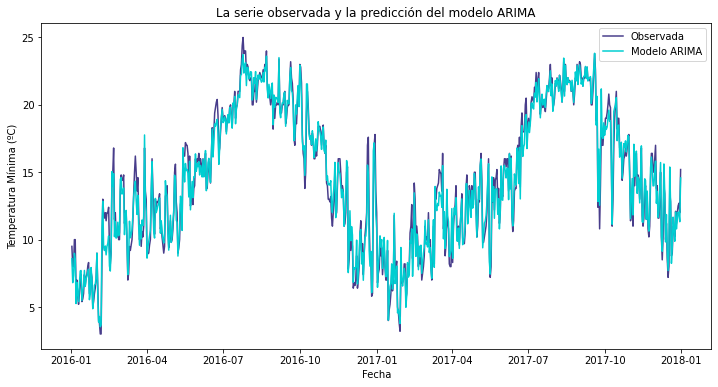

In [100]:
# Graficamos sólo los útimos datos de las series 
ts_PruebaMin_last = ts_Prueba_Min.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)
plt.plot(ts_PruebaMin_last, label='Observada', color='darkslateblue');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA', color='darkturquoise');
plt.xlabel('Fecha')
plt.ylabel('Temperatura Mínima (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA')
plt.legend(loc='best');